### Cubic Spline

Построим с помощью наклонов.

In [28]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rc('figure', figsize=(15, 6))

In [29]:
def check_convex(x,y):
    for i in range(1, len(x) - 1):
        if ((y[i+1] - 2*y[i] + y[i-1])/(x[i+1] - x[i])**2) < 0:
            print(f"Not convex from {x[i]}")
            return
    print("Convex is ok")
    return
def check_monot(x,y):
    for i in range(len(y) - 2):
        if y[i+1] < y[i]:
            print(f"Not monot from {x[i]}")
            return
    print("Monot is ok")
    return

In [30]:
def omega_div_omega_last(x_inext, x_i, x_ilast, f_inext, f_i, f_ilast):
    fl_f = 0
    if abs(f_inext - f_i) < 1e-14:
        if abs(f_i - f_ilast) < 1e-14:
            fl_f = (1 / (x_i - x_ilast)) / (1 / (x_inext - x_i))
        else:
            return 1e10
    else:
        fl_f = ((f_i - f_ilast) / (x_i - x_ilast)) / \
            ((f_inext - f_i) / (x_inext - x_i))
    # print(fl_f)
    return (fl_f - 2) * (x_inext - x_i) / (x_i - x_ilast)


def omega_last_div_omega(x_inext, x_i, x_ilast, f_inext, f_i, f_ilast):
    fl_f = 0
    if abs(f_i - f_ilast) < 1e-14:
        if abs(f_inext - f_i) < 1e-14:
            fl_f = (1 / (x_inext - x_i)) / (1 / (x_i - x_ilast))
        else:
            return 1e10
    else:
        fl_f = ((f_inext - f_i) / (x_inext - x_i)) / \
            ((f_i - f_ilast) / (x_i - x_ilast))
    # print(fl_f)
    return (fl_f - 2) * (x_i - x_ilast) / (x_inext - x_i)


def omega_finding(x, f):
    """
     По векторам x и f функция строит набор весов, при котором весовой сплайн является монотонным.

     :param x: точки, на которых задана функция (вектор длины n)
     :param f: значения функции в соответствующих точках (вектор длины n)
     :return: набор весов (вектор длины n - 1)
    """
    mon_omegas = np.ones(len(x) - 1)

    for i in range(1, len(mon_omegas) - 1):
        o_div_o_last = omega_div_omega_last(
            x[i + 1], x[i], x[i - 1], f[i + 1], f[i], f[i - 1])
        o_last_div_o = omega_last_div_omega(
            x[i + 1], x[i], x[i - 1], f[i + 1], f[i], f[i - 1])
        

        # print(o_div_o_last, o_last_div_o)
        if o_div_o_last <= 0 and o_last_div_o <= 0:
            mon_omegas[i] = 1
        #  print("<0 <0 ", mon_omegas[i])
        elif o_div_o_last > 0 and o_last_div_o <= 0:
            mon_omegas[i] = o_div_o_last * mon_omegas[i -
                                                      1] if o_div_o_last > 1 else mon_omegas[i - 1]
        #  print(">0 <0 ", o_div_o_last * mon_omegas[i - 1])
        elif o_div_o_last <= 0 and o_last_div_o > 0:
            mon_omegas[i] = mon_omegas[i - 1] / \
                o_last_div_o if o_div_o_last < 1 else mon_omegas[i - 1]
        #  print("<0 >0 ", mon_omegas[i - 1] / o_last_div_o)
        elif o_div_o_last > 0 and o_last_div_o > 0:
            #  print(">0 >0 ")
            if o_div_o_last < 1 and o_last_div_o < 1:
                mon_omegas[i] = mon_omegas[i - 1]
            elif abs(o_div_o_last * mon_omegas[i - 1] - mon_omegas[i]) < abs(mon_omegas[i - 1] / o_last_div_o - mon_omegas[i]):
                mon_omegas[i] = o_div_o_last * mon_omegas[i - 1]
            else:
                mon_omegas[i] = mon_omegas[i - 1] / o_last_div_o
        
        # print(o_div_o_last, o_div_o_last, mon_omegas[i - 1], mon_omegas[i])

    return mon_omegas

In [33]:
def cubic_spline(x, y, w):
    n = len(x) - 1
    h = np.diff(x)
    f = np.diff(y) / h

    lambda_ = np.array(
        [w[i-1] * h[i] / (w[i-1] * h[i] + w[i] * h[i-1]) for i in range(1, n)]
    )

    mu = 1 - lambda_

    c = np.array(
        [3 * lambda_[i-1] * f[i-1] + 3 * mu[i-1] * f[i] for i in range(1, n)]
    )

    matrix = np.zeros((n-1, n-1))
    np.fill_diagonal(matrix, 2)
    np.fill_diagonal(matrix[1:], lambda_[1:])
    np.fill_diagonal(matrix[:, 1:], mu[:-1])
    m = np.linalg.solve(matrix, c)

    # m = np.concatenate(([0], m, [0]))
    # m = 9*(x**2) + 4*x+1
    m = np.zeros_like(x)
    for index, x_i in enumerate(x):
        if x_i <= 5:
            m[index] = 9*(x_i**2) + 4*x_i+1 
        else:
            m[index] = 1

    def S(xi):
        i = np.searchsorted(x, xi) - 1
        i = np.clip(i, 0, n-1)
        t = (xi - x[i]) / h[i]
        return ((1-t)**2 * (2*t+1) * y[i] + t**2 * (3-2*t) * y[i+1] +
                (1-t)**2 * t * m[i] * h[i] - t**2 * (1-t) * m[i+1] * h[i])

    return S

# x = np.linspace(0, 1, 100)
# y = x**2
# w = np.ones_like(x)

# S = cubic_spline(x, y, w)

# xi = np.linspace(min(x), max(x), 1000)
# yi = S(xi)
# plt.plot(xi, yi)
# plt.scatter(x, y, color = 'blue')
# plt.show()

### Test

Not convex from 5.405405405405405
Monot is ok


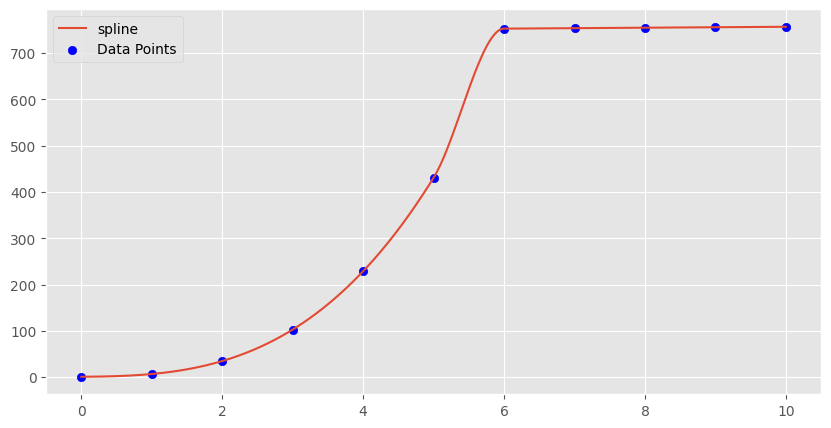

[0.         0.55555556 1.11111111 1.66666667 2.22222222 2.77777778
 3.33333333 3.88888889 4.44444444 5.        ]
[  1.           2.6872428    8.69547325  22.11111111  46.02057613
  83.51028807 137.66666667 211.57613169 308.32510288 431.        ]
1.0
2.6872427983539096
8.695473251028808
22.111111111111118
46.02057613168725
83.51028806584361
137.6666666666667
211.57613168724285
308.3251028806585
431.0


In [35]:
def test_func(x):
    if x <= 5: 
        return 3*x**3 + 2*x**2 + x + 1
    else:
        return x + 747
    # return (1 - x**2)**0.5
    # return 1/(25*(x**2) + 1)

x = np.linspace(0, 10, 11)
y = np.zeros_like(x)
for index, x_i in enumerate(x):
    y[index] = test_func(x_i)

# x = np.linspace(-1,-0.12,10)
# y = func(x)
w = np.ones_like(x)
# w = omega_finding(x, y)

S = cubic_spline(x, y, w)
xi = np.linspace(min(x), max(x), 1000)
yi = S(xi)
check_convex(xi,yi)
check_monot(xi,yi)

plt.figure(figsize=(10, 5))
plt.plot(xi, yi, label='spline')
#plt.plot(xi, rk(xi), label='Original Runge', color = 'purple')
plt.scatter(x, y, color='blue', label='Data Points')
plt.legend()
plt.grid(True)
plt.show()

x = np.linspace(0, 5, 10)
print(x)
print(S(x))
for index, x_i in enumerate(x):
    # y[index] = test_func(x_i)
    print(test_func(x_i))

Not convex from 0.005005005005005005
Not monot from 0.08508508508508508


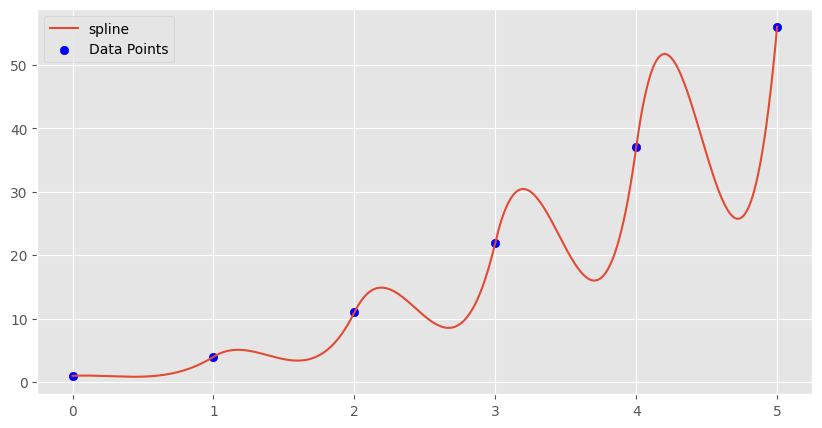

[1. 3. 1. 1. 1.]
[0. 1. 2. 3. 4. 5.]
[ 1.  4. 11. 22. 37. 56.]
[ 1.  4. 11. 22. 37. 56.]


In [ ]:
def test_func(x):
    return 2*x**2+x+1
    # return (1 - x**2)**0.5
    # return 1/(25*(x**2) + 1)

x = np.linspace(0, 5, 6)
y = test_func(x)

# x = np.linspace(-1,-0.12,10)
# y = func(x)
w = np.ones_like(x)
w = omega_finding(x, y)

S = cubic_spline(x, y, w)
xi = np.linspace(min(x), max(x), 1000)
yi = S(xi)
check_convex(xi,yi)
check_monot(xi,yi)

plt.figure(figsize=(10, 5))
plt.plot(xi, yi, label='spline')
#plt.plot(xi, rk(xi), label='Original Runge', color = 'purple')
plt.scatter(x, y, color='blue', label='Data Points')
plt.legend()
plt.grid(True)
plt.show()
print(w)
print(x)
print(S(x))
print(test_func(x))

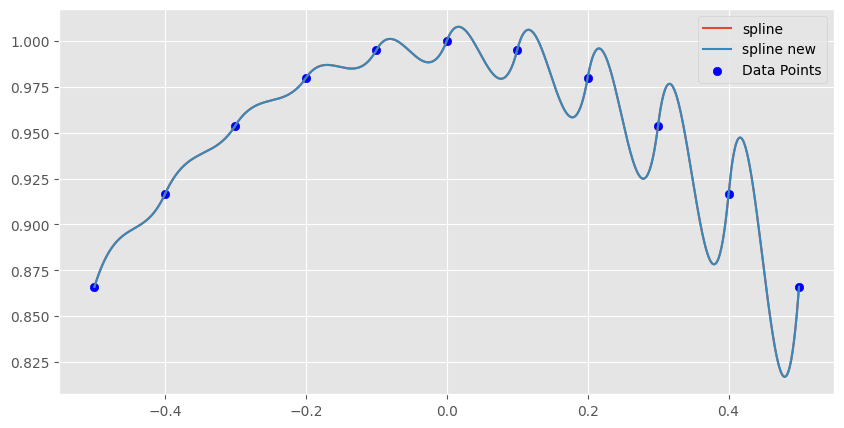

In [ ]:
def test_func(x):
    return (1 - x**2)**0.5
    # return 1/(25*(x**2) + 1)

x = np.linspace(-0.5, 0.5, 11)
y = test_func(x)
w = np.ones_like(x)

S = cubic_spline(x, y, w)
xi = np.linspace(min(x), max(x), 1000)
yi = S(xi)
# check_convex(xi,yi)
# check_monot(xi,yi)

w[3] = 100
S_new = cubic_spline(x, y, w)
yi_new = S_new(xi)

plt.figure(figsize=(10, 5))
plt.plot(xi, yi, label='spline')
plt.plot(xi, yi_new, label='spline new')
#plt.plot(xi, rk(xi), label='Original Runge', color = 'purple')
plt.scatter(x, y, color='blue', label='Data Points')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# x = np.array([6, 8, 9, 11, 12, 14, 15, 16])
# f = np.array([10, 10, 10.5, 15, 50, 60, 85, 110])

# net = np.linspace(min(x), max(x[:-1]), 100)

# omegas = omega_finding(x, f)

# p = cubic_spline(x, f, omegas)
# plt.plot(net, p(net))


# p1 = cubic_spline(x, f,  np.ones(len(omegas)))
# plt.plot(net, p1(net))
# plt.scatter(x[:-1], f[:-1])